# 9.4 향후 판매량 예측 경진대회 모델 성능 개선

- 이번 장에서는 피처 엔지니어링에 집중
 - 개별 데이터, 즉 sales_train, shops, items, item_categories를 활용해 전처리, 파생 피처 생성, 인코딩 수행
 - (기준 피처별 원간 평균 판매량 피처의) 시차 피처 생성
 - 그 외 추가적인 피처 엔지니어링 적용

<div>
    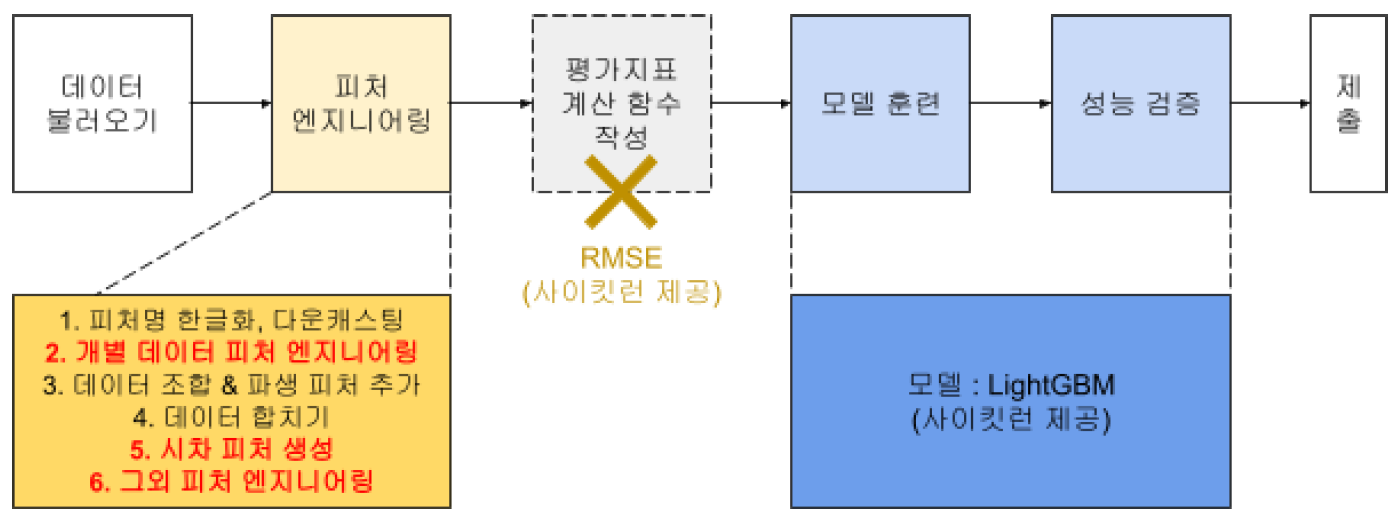
</div>

In [ ]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore') # 경고 메시지 생략

# 데이터 경로
data_path = '/kaggle/input/competitive-data-science-predict-future-sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

## 9.4.1 피처 엔지니어링 I : 피처명 한글화와 데이터 다운캐스팅

In [ ]:
sales_train = sales_train.rename(columns={'date': '날짜', 
                                          'date_block_num': '월ID',
                                          'shop_id': '상점ID',
                                          'item_id': '상품ID',
                                          'item_price': '판매가',
                                          'item_cnt_day': '판매량'})

shops = shops.rename(columns={'shop_name': '상점명',
                              'shop_id': '상점ID'})

items = items.rename(columns={'item_name': '상품명',
                              'item_id': '상품ID',
                              'item_category_id': '상품분류ID'})

item_categories = item_categories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})

test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

In [ ]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

## 9.4.2 피처 엔지니어링 II : 개별 데이터 피처 엔지니어링

- sales_train, shops, items, item_categories 데이터를 ‘각각’ 피처 엔지니어링

### sales_train 이상치 제거 및 전처리
 - 판매가, 판매량이 음수라면 환불 건이거나 오류이므로 이상치로 간주
 - #### **<font color='orange'> 일별 판매량 1,000 이상인 데이터(이상치) 제거 </font>**
 - #### **<font color='orange'> 판매가 50,000 이상인 데이터(이상치) 제거 </font>**

In [ ]:
# 판매가가 0보다 큰 데이터 추출
sales_train = sales_train[sales_train['판매가'] > 0]
# 판매가가 50,000보다 작은 데이터 추출
sales_train = sales_train[sales_train['판매가'] < 50000]

# 판매량이 0보다 큰 데이터 추출
sales_train = sales_train[sales_train['판매량'] > 0]
# 판매량이 1,000보다 작은 데이터 추출
sales_train = sales_train[sales_train['판매량'] < 1000]

- 상점명을 조금 다르게 기입해서 같은 상점인데 따로 기록돼 있는 상점이 네 쌍 있음
- 다음 상점명 네 쌍을 같은 의미로 간주

In [ ]:
print(shops['상점명'][0], '||', shops['상점명'][57])
print(shops['상점명'][1], '||', shops['상점명'][58])
print(shops['상점명'][10], '||', shops['상점명'][11])
print(shops['상점명'][39], '||', shops['상점명'][40])

- 0 vs. 57
 - !Якутск Орджоникидзе, 56 фран
 - Якутск Орджоникидзе, 56
- 1 vs. 58
 - !Якутск ТЦ "Центральный" фран
 - Якутск ТЦ "Центральный"
- 10 vs. 11
 - Жуковский ул. Чкалова 39м?
 - Жуковский ул. Чкалова 39м²
- 39 vs. 40
 - РостовНаДону ТРК "Мегацентр Горизонт"
 - РостовНаДону ТРК "Мегацентр Горизонт" Островной

- 상점명은 그대로 두고 상점ID만 수정
 - 상점명과 상점ID가 결국 일대일 매칭되고, 상점명은 문자 데이터라 나중에 제거할 예정이기 때문!

In [ ]:
# sales_train 데이터에서 상점ID 수정
sales_train.loc[sales_train['상점ID'] == 0, '상점ID'] = 57
sales_train.loc[sales_train['상점ID'] == 1, '상점ID'] = 58
sales_train.loc[sales_train['상점ID'] == 10, '상점ID'] = 11
sales_train.loc[sales_train['상점ID'] == 39, '상점ID'] = 40

# test 데이터에서 상점ID 수정
test.loc[test['상점ID'] == 0, '상점ID'] = 57
test.loc[test['상점ID'] == 1, '상점ID'] = 58
test.loc[test['상점ID'] == 10, '상점ID'] = 11
test.loc[test['상점ID'] == 39, '상점ID'] = 40

### shops 파생 피처 생성 및 인코딩
- #### **<font color='orange'> 상점 이름의 첫 단어는 상점이 위치한 도시를 뜻함 </font>**

In [ ]:
shops['도시'] = shops['상점명'].apply(lambda x: x.split()[0])

In [ ]:
shops['도시'].unique()

- !Якутск 앞의 느낌표(!)는 잘못 기재된 것이니 제거

In [ ]:
shops.loc[shops['도시'] =='!Якутск', '도시'] = 'Якутск'

- 도시명 레이블 인코딩
 - 도시명은 범주형 피처임
 - 머신러닝 모델은 문자를 인식하지 못하므로 숫자로 바꿔야 함

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 생성
label_encoder = LabelEncoder()
# 도시 피처 레이블 인코딩
shops['도시'] = label_encoder.fit_transform(shops['도시'])

- 상점명 피처 제거
 - 상점명 피처는 도시명 피처를 만들기 위해 필요했음
 - 상점명 피처가 더는 필요 없으니 제거(같은 의미가 상점ID 피처에 내포돼 있기 때문)

In [ ]:
# 상점명 피처 제거
shops = shops.drop('상점명', axis=1)

shops.head()

### items 파생 피처 생성
- #### **<font color='orange'> 상품명 피처 제거 </font>**
 - 우선, items 데이터는 상품명, 상품ID, 상품분류ID를 피처로 갖음 (상품명은 상품ID와 일대일 매칭되므로 제거)

In [ ]:
# 상품명 피처 제거
items = items.drop(['상품명'], axis=1)

- 첫 판매월 피처 생성
 - 판매 내역 데이터(sales_train)에서 상품ID가 가장 처음 등장한 날의 월ID를 구하면 됨
 - 첫 판매월 피처는 모델링에 직접 사용하지 않고, 추후 다른 피처를 만들 때 활용됨

In [ ]:
# 상품이 맨 처음 팔린 날을 피처로 추가
items['첫 판매월'] = sales_train.groupby('상품ID').agg({'월ID': 'min'})['월ID']

items.head()

- 첫 판매월 결측값 처리
 - 결측값은 해당 상품이 한 번도 판매된 적 없다는 뜻
 - 첫 판매월의 결측값은 2015년 11월로 가정해도 문제 없음(월ID=34)

<div>
    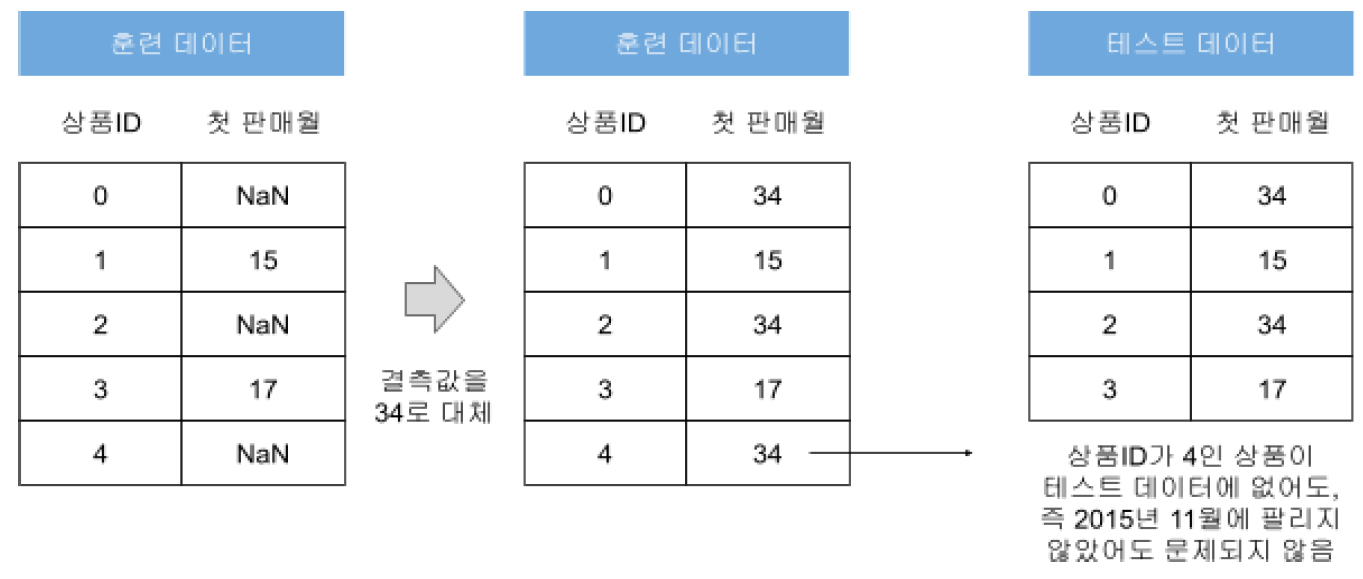
</div>

In [ ]:
items[items['첫 판매월'].isna()]

In [ ]:
# 첫 판매월 피처의 결측값을 34로 대체
items['첫 판매월'] = items['첫 판매월'].fillna(34)

### item_categories 파생 피처 생성 및 인코딩
- item_categories에서 ‘대분류’ 파생 피처 만들고, 이를 인코딩
 - #### **<font color='orange'> 상품분류명에서 첫 단어는 대분류, 이를 참고해 대분류 추출 </font>**
 - 범주형 데이터를 더 큰 범주로 묶으면 범주가 지나치게 세밀할 때보다 성능 향상에 유리할 수도 있음

In [ ]:
# 상품분류명의 첫 단어를 대분류로 추출
item_categories['대분류'] = item_categories['상품분류명'].apply(lambda x: x.split()[0])  

In [ ]:
item_categories['대분류'].value_counts()

- 고윳값 5개 미만인 대분류는 ‘etc’로 변환
 - 대분류 하나가 범주를 일정 개수 이상을 갖는 게 성능 향상에 유리하기 때문

In [ ]:
def make_etc(x):
    if len(item_categories[item_categories['대분류']==x]) >= 5:
        return x
    else:
        return 'etc'

# 대분류의 고윳값 개수가 5개 미만이면 'etc'로 바꾸기
item_categories['대분류'] = item_categories['대분류'].apply(make_etc)

In [ ]:
item_categories.head()

- 범주형 피처인 대분류 인코딩 후 더 이상 필요 없는 상품분류명 피처 제거

In [ ]:
# 레이블 인코더 생성
label_encoder = LabelEncoder()

# 대분류 피처 레이블 인코딩
item_categories['대분류'] = label_encoder.fit_transform(item_categories['대분류'])

# 상품분류명 피처 제거
item_categories = item_categories.drop('상품분류명', axis=1)

<div>
    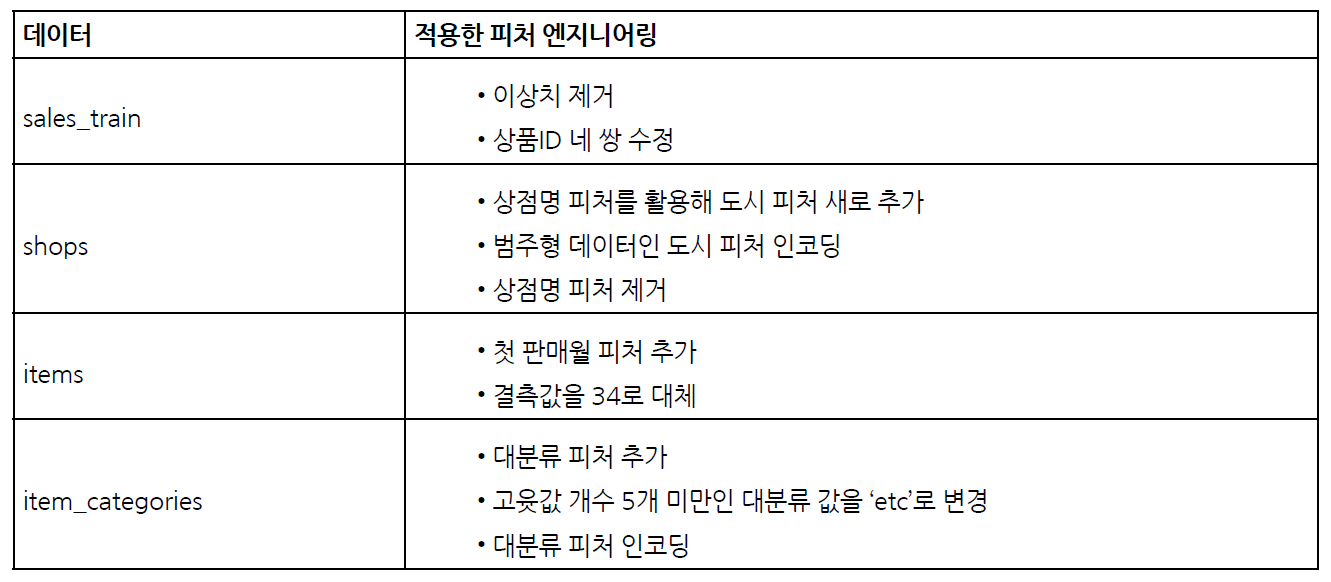
</div>

## 9.4.3 피처 엔지니어링 III : 데이터 조합 및 파생 피처 생성

### 데이터 조합

In [ ]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
train = pd.DataFrame(np.vstack(train), columns=idx_features)

### 파생 피처 생성
- 3가지 피처 생성(‘월간 판매량’, ‘평균 판매가’, ‘기준 피처별 상품 판매건수’)
- 먼저, 월간 판매량과 평균 판매가 피처 생성 (베이스라인과 다르게 평균 판매가도 추가)

In [ ]:
group = sales_train.groupby(idx_features).agg({'판매량': 'sum',
                                               '판매가': 'mean'})
group = group.reset_index()
group = group.rename(columns={'판매량': '월간 판매량', '판매가': '평균 판매가'})

train = train.merge(group, on=idx_features, how='left')

train.head()

- 결측값이 있다는 건 판매량과 판매가가 0이라는 뜻
- 추후 결측값은 0으로 대체

In [ ]:
import gc

# group 변수 가비지 컬렉션
del group
gc.collect();

- ‘기준 피처별 상품 판매건수’ 피처 추가
 - ex) 엊그제 3개, 어제 0개, 오늘 2개 팔았다면 판매량은 5개, 판매건수는 2건
 - 당일에 한 번이라도 팔았으면 건수가 1건, 팔지 못했다면 0건

In [ ]:
# 상품 판매건수 피처 추가
group = sales_train.groupby(idx_features).agg({'판매량': 'count'})
group = group.reset_index()
group = group.rename(columns={'판매량': '판매건수'})

train = train.merge(group, on=idx_features, how='left')

# 가비지 컬렉션
del group, sales_train
gc.collect()

train.head()

- 판매건수 결측값도 추후 0으로 대체

## 9.4.4 피처 엔지니어링 IV : 데이터 합치기

### 테스트 데이터 이어붙이기

In [ ]:
# 테스트 데이터 월ID를 34로 설정
test['월ID'] = 34

# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

### 모든 데이터 병합

In [ ]:
# 나머지 데이터 병합
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

# 데이터 다운캐스팅
all_data = downcast(all_data)

In [ ]:
# 가비지 컬렉션
del shops, items, item_categories
gc.collect();

## 9.4.5 피처 엔지니어링 V : 시차 피처 생성
- 시차 피처란?
 - 시차 피처(time lag feature)란 과거 시점에 관한 피처(시계열에 자주 사용되는 파생 피처)
 - 현시점 데이터에 과거 시점 데이터를 추가한다는 개념(트렌드 반영)
 - 과거 시점 데이터는 향후 판매량 예측에 유용하기 때문에 사용
- 시차 피처 생성 절차
 - 기준 피처별 시차 피처 생성
 - 기준 피처는 다양하게 정할 수 있음
 <div>
    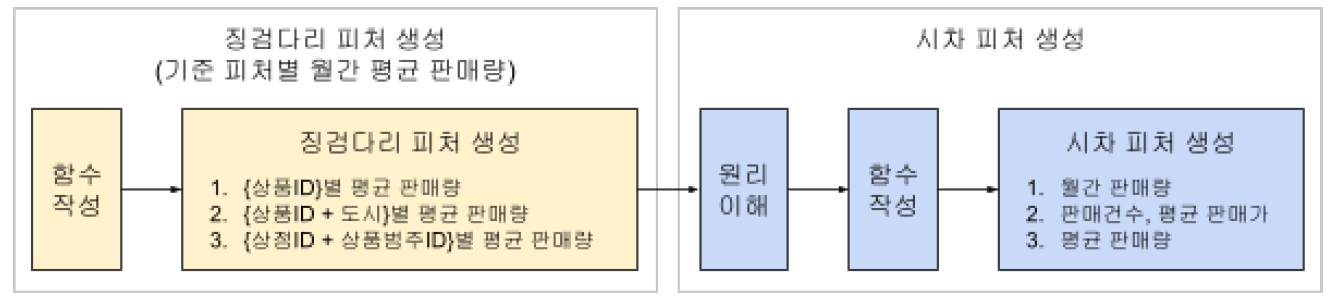
</div>

### 기준 피처별 월간 평균 판매량 파생 피처 생성
- 기준 피처로 그룹화해 월간 평균 판매량을 구하는 함수 정의
 - df : 작업할 전체 DataFrame
 - mean_features : 새로 만든 월간 평균 판매량 파생 피처명을 저장하는 리스트
 - idx_features : 기준 피처
- 기준 피처의 첫 번째 요소는 반드시 ‘월ID’여야 함 (‘월간’ 평균 판매량 파생 피처를 만드므로)
- 기준 피처가 많으면 지나치게 세분화되므로 기준 피처 개수는 2개나 3개로 설정

In [ ]:
def add_mean_features(df, mean_features, idx_features):
    # 기준 피처 확인 
    assert (idx_features[0] == '월ID') and \
           len(idx_features) in [2, 3]
    
    # 파생 피처명 설정 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '별 평균 판매량'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '별 평균 판매량'
    
    # 기준 피처를 토대로 그룹화해 월간 평균 판매량 구하기 
    group = df.groupby(idx_features).agg({'월간 판매량': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'월간 판매량': feature_name})
    
    # df와 group 병합 
    df = df.merge(group, on=idx_features, how='left')
    # 데이터 다운캐스팅 
    df = downcast(df, verbose=False)
    # 새로 만든 feature_name 피처명을 mean_features 리스트에 추가 
    mean_features.append(feature_name)
    
    # 가비지 컬렉션
    del group
    gc.collect()
    
    return df, mean_features

- [‘월ID’, ‘상품ID’]별 월간 평균 판매량, [‘월ID’, ‘상품ID’, ‘도시’]별 월간 평균 판매량 생성

In [ ]:
# 그룹화 기준 피처 중 '상품ID'가 포함된 파생 피처명을 담을 리스트
item_mean_features = []

# ['월ID', '상품ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID'])

# ['월ID', '상품ID', '도시']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID', '도시'])

- item_mean_features는 ‘기준 피처에 상품ID를 포함하는 파생 피처’명을 저장한 리스트
- 추후 이 리스트에 저장된 파생 피처명을 활용해 시차 피처를 생성할 것임

In [ ]:
item_mean_features

- 이번엔 [‘월ID’, ‘상점ID’, ‘상품분류ID’]별 월간 평균 판매량 생성

In [ ]:
# 그룹화 기준 피처 중 '상점ID'가 포함된 파생 피처명을 담을 리스트
shop_mean_features = []

# ['월ID', '상점ID', '상품분류ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['월ID', '상점ID', '상품분류ID'])

In [ ]:
shop_mean_features

### 시차 피처 생성 원리와 함수 구현
- 지금까지 만든 기준 피처별 월간 평균 판매량 피처
 - {상품ID}별 평균 판매량
 - {상품ID + 도시}별 평균 판매량
 - {상점ID + 상품분류ID}별 평균 판매량
- 시차 피처 생성 원리
 1. 기준 피처와 ‘시찻값을 구하려는 피처’ 정하기
 2. 원본 데이터에서 기준 피처와 ‘시찻값을 구하려는 피처’만 추출해 복사
 3. 새로 만들 시차 피처명 정하기
 4. df_temp에서 ‘월간 판매량’을 ‘월간 판매량_시차1’로 변경
 5. df_temp의 ‘월ID’ 피처에 1을 더함
 6. 기준 피처를 토대로 df와 df_temp 병합
 
<div>
    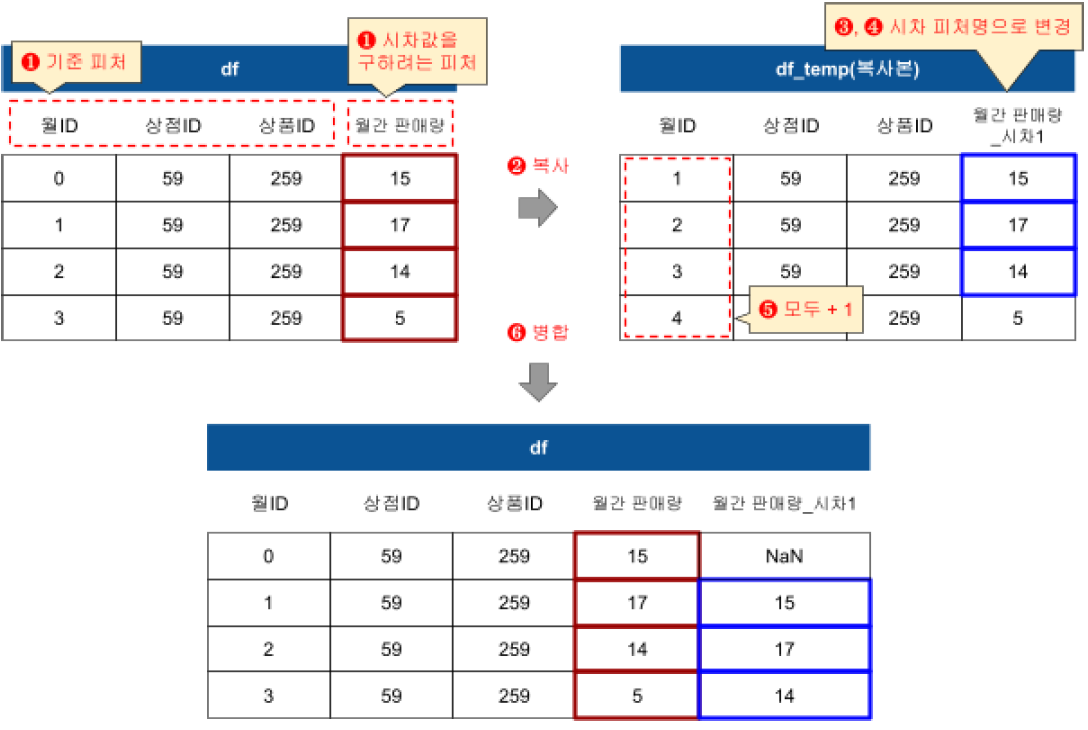
</div>

In [ ]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # 시차 피처 생성에 필요한 DataFrame 부분만 복사 
    df_temp = df[idx_features + [lag_feature]].copy() 

    # 시차 피처 생성 
    for i in range(1, nlags+1):
        # 시차 피처명 
        lag_feature_name = lag_feature +'_시차' + str(i)
        # df_temp 열 이름 설정 
        df_temp.columns = idx_features + [lag_feature_name]
        # df_temp의 date_block_num 피처에 1 더하기 
        df_temp['월ID'] += 1
        # idx_feature를 기준으로 df와 df_temp 병합하기 
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # 결측값 0으로 대체 
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # 0 ~ 20 사이로 제한할 시차 피처명을 lag_features_to_clip에 추가 
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # 데이터 다운캐스팅
    df = downcast(df, False)
    # 가비지 컬렉션
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

### 시차 피처 생성 I : 월간 판매량
- ‘월ID’, ‘상점ID’, ‘상품ID’를 기준으로 월간 판매량의 세 달치 시차 피처 만들기

In [ ]:
lag_features_to_clip = [] # 0 ~ 20 사이로 제한할 시차 피처명을 담을 리스트
idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처

# idx_features를 기준으로 월간 판매량의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='월간 판매량', 
                                                  nlags=3,
                                                  clip=True) # 값을 0 ~ 20 사이로 제한

In [ ]:
all_data.head().T

In [ ]:
lag_features_to_clip

### 시차 피처 생성 II : 판매건수, 평균 판매가
- 판매건수와 평균 판매가는 0~20 사이로 제한할 필요가 없어서 clip 파라미터 생략

In [ ]:
# idx_features를 기준으로 판매건수 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='판매건수', 
                                                  nlags=3)

# idx_features를 기준으로 평균 판매가 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='평균 판매가', 
                                                  nlags=3)

### 시차 피처 생성 III : 평균 판매량
- item_mean_features와 shop_mean_features에 저장된 평균 판매량 피처를 활용해 시차 피처 생성

In [ ]:
# idx_features를 기준으로 item_mean_features 요소별 시차 피처 생성
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# item_mean_features 피처 제거
all_data = all_data.drop(item_mean_features, axis=1)

In [ ]:
# ['월ID', '상점ID', '상품분류ID']를 기준으로 shop_mean_features 요소별 시차 피처 생성
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['월ID', '상점ID', '상품분류ID'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# shop_mean_features 피처 제거
all_data = all_data.drop(shop_mean_features, axis=1)

### 시차 피처 생성 마무리 : 결측값 처리
- 세 달치 시차 피처를 만들었으므로 자연스럽게 월ID가 0, 1, 2인 데이터에 결측값이 생김
<div>
    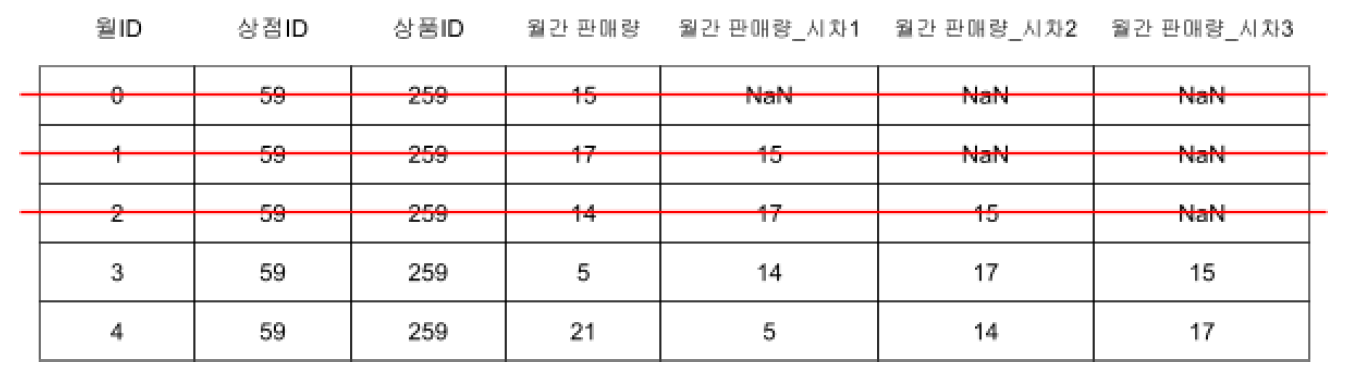
</div>

In [ ]:
# 월ID 3미만인 데이터 제거 (결측값 제)
all_data = all_data.drop(all_data[all_data['월ID'] < 3].index)

## 9.4.6 피처 엔지니어링 VI : 기타 피처 엔지니어링

### 기타 피처 추가

#### 월간 판매량 시차 피처들의 평균

In [ ]:
all_data['월간 판매량 시차평균'] = all_data[['월간 판매량_시차1',
                                          '월간 판매량_시차2', 
                                          '월간 판매량_시차3']].mean(axis=1)

In [ ]:
# 0 ~ 20 사이로 값 제한
all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']] = all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']].clip(0, 20)

#### 시차 변화량

<div>
    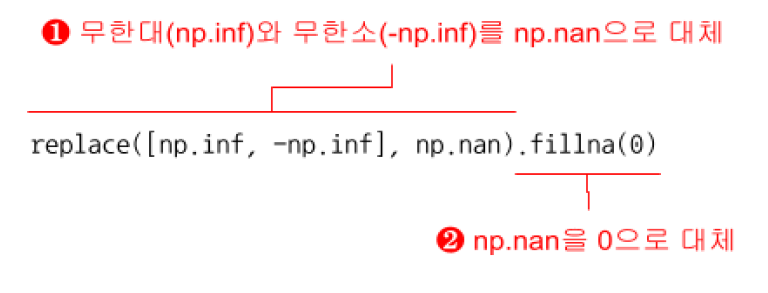
</div>

In [ ]:
all_data['시차변화량1'] = all_data['월간 판매량_시차1']/all_data['월간 판매량_시차2']
all_data['시차변화량1'] = all_data['시차변화량1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['시차변화량2'] = all_data['월간 판매량_시차2']/all_data['월간 판매량_시차3']
all_data['시차변화량2'] = all_data['시차변화량2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

#### 신상 여부
- 첫 판매월이 현재 월과 같다면 신상품

In [ ]:
all_data['신상여부'] = all_data['첫 판매월'] == all_data['월ID']

#### 첫 판매 후 경과 기간

In [ ]:
all_data['첫 판매 후 기간'] = all_data['월ID'] - all_data['첫 판매월']

#### 월(month)
- 월ID 피처를 12로 나눈 나머지

In [ ]:
all_data['월'] = all_data['월ID'] % 12

### 필요 없는 피처 제거
- 첫 판매월, 평균 판매가, 판매건수
 - 첫 판매월은 ‘신상 여부’와 ‘첫 판매 후 기간’ 피처를 구하는 데 쓰임
 - 평균 판매가와 판매건수는 테스트 데이터에서 모두 0임

In [ ]:
# 첫 판매월, 평균 판매가, 판매건수 피처 제거
all_data = all_data.drop(['첫 판매월', '평균 판매가', '판매건수'], axis=1)

In [ ]:
all_data = downcast(all_data, False) # 데이터 다운캐스팅

## 9.4.7 피처 엔지니어링 VII : 마무리

In [ ]:
all_data.info()

In [ ]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['월ID'] < 33]['월간 판매량']
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['월ID'] == 33]['월간 판매량']

# 가비지 컬렉션
del all_data
gc.collect();

## 9.4.8 모델 훈련 및 성능 검증

In [ ]:
import lightgbm as lgb

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse', 
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise': True,
          'random_state': 10}

cat_features = ['상점ID', '도시', '상품분류ID', '대분류', '월']

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)      

## 9.4.9 예측 및 결과 제출

In [ ]:
# 예측
preds = lgb_model.predict(X_test).clip(0, 20)

# 제출 파일 생성
submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index=False)

In [ ]:
del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
gc.collect();

- 제출 결과: 0.8701

1. 훈련 데이터가 여러 파일로 제공되면 공통 피처를 기준으로 병합해 사용
2. 타깃값이 직접적으로 제공되지 않기도 함, 이럴 땐 존재하는 피처를 조합하거나 계산해 타깃값을 구해야 함
3. 회귀 문제에서는 특정 피처를 기준으로 데이터를 그룹화해 값을 집계해 사용하는 일이 많음
4. 피처가 다양할 때는 피처명을 한글화하는 것도 좋은 방법임
5. 데이터가 크면 메모리 관리도 신경 써야 함(데이터 다운캐스팅, 가비지 컬렉션)
6. 이상치가 있을 대는 해당 데이터 자체를 제거하거나 적절한 값으로 바꿔줘야 함
7. 둘 이상의 피처를 조합하면 유용한 데이터의 수가 늘어나는 효과가 있음
8. 분류 피처의 각 분류별 데이터 수가 적다면 대분류로 다시 묶어 훈련하는 것도 좋은 방법임
9. 시계열 데이터에서는 시간 흐름 자체가 중요한 정보임
10. 시차 피처란 과거 시점에 관한 피처로, 성능 향상에 도움되는 경우가 많아서 시계열 문제에서 자주 만드는 파생 피처임